In [1]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten, TimeDistributed, Reshape, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from datetime import datetime

Using TensorFlow backend.


In [2]:
# Load the data
df_train = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df_train.head()


,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [3]:
df_test = pd.read_csv('../../data/cleaned/site2_bird.csv')
df_test.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1
1,5/5/2017,0:15,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1
2,5/5/2017,0:30,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2
3,5/5/2017,0:45,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2
4,5/5/2017,1:00,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1


In [4]:
# Merge time units
df_train['time'] = pd.to_datetime(
    df_train['Date (mm.dd.yyyy)'] + ' '+ df_train['Time 24hr'])
df_train.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,time
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4,2017-05-05 01:00:00


In [5]:
df_test['time'] = pd.to_datetime(
    df_test['Date (mm.dd.yyyy)'] + ' '+ df_test['Time 24hr'])
df_test.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,time
0,5/5/2017,0:00,15.37,2184,-100.0,8.41,10.70,2.7,0.7,92.2,9.16,0.1,2017-05-05 00:00:00
1,5/5/2017,0:15,15.45,2139,-101.0,8.43,9.92,2.7,0.7,93.3,9.25,0.1,2017-05-05 00:15:00
2,5/5/2017,0:30,15.49,2057,-102.3,8.45,8.90,2.8,0.7,94.8,9.40,0.2,2017-05-05 00:30:00
3,5/5/2017,0:45,15.67,1978,-102.6,8.45,8.62,2.7,0.7,96.0,9.49,0.2,2017-05-05 00:45:00
4,5/5/2017,1:00,15.34,2136,-100.2,8.41,9.88,2.6,0.7,92.7,9.22,0.1,2017-05-05 01:00:00


In [6]:
# dont need data and time now that we have Timestamp. Lets remove them

df_train = df_train.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
df_test = df_test.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])

In [7]:
print(df_train.dtypes)
df_test.dtypes

Temp C                        float64
Sp Cond (uS/cm)                 int64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
time                   datetime64[ns]
dtype: object


Temp C                        float64
Sp Cond (uS/cm)                 int64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
time                   datetime64[ns]
dtype: object

In [8]:
df_train['Sp Cond (uS/cm)'] = df_train['Sp Cond (uS/cm)'].astype('float64')
df_test['Sp Cond (uS/cm)'] = df_test['Sp Cond (uS/cm)'].astype('float64')
print(df_train.dtypes)
df_test.dtypes

Temp C                        float64
Sp Cond (uS/cm)               float64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
time                   datetime64[ns]
dtype: object


Temp C                        float64
Sp Cond (uS/cm)               float64
pH (mV)                       float64
pH                            float64
Turbidity (NTU)               float64
Chlorophyll (ug/L)            float64
Chlorophyll RFU               float64
ODOSat%                       float64
ODO (mg/L)                    float64
BGA-Phycocyanin RFU           float64
time                   datetime64[ns]
dtype: object

In [9]:
# lets try to normalize this now....
columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)',
           'ODOSat%','ODO (mg/L)']
scaler = MinMaxScaler()
df_train_x = scaler.fit_transform(df_train[columns])
df_test_x = scaler.fit_transform(df_test[columns])

df_train_x = pd.DataFrame(df_train_x, columns=columns)
df_test_x = pd.DataFrame(df_test_x, columns=columns)

# df_train_x['Chlorophyll RFU'] = df_train['Chlorophyll RFU']
# df_test_x['Chlorophyll RFU'] = df_test['Chlorophyll RFU']

df_train_x['BGA-Phycocyanin RFU'] = df_train['BGA-Phycocyanin RFU']
df_test_x['BGA-Phycocyanin RFU'] = df_test['BGA-Phycocyanin RFU']



df_test_x.describe()


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000,17095.000000
mean,0.557140,0.858878,0.206929,0.800655,0.014204,0.503941,0.599940,0.762550
std,0.280796,0.057788,0.086697,0.091744,0.020237,0.083285,0.120033,0.630421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.280773,0.829966,0.167293,0.759563,0.006112,0.483530,0.524031,0.400000
50%,0.619946,0.855640,0.190789,0.814208,0.008997,0.504040,0.611628,0.600000
75%,0.815139,0.881313,0.240602,0.857923,0.014504,0.523928,0.695349,0.900000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.600000


# Visualizing the data

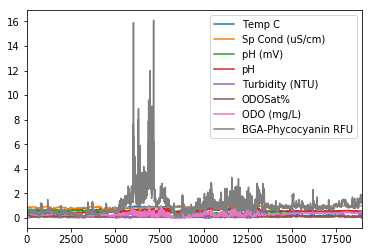

In [10]:
df_train_x[columns].plot.line()

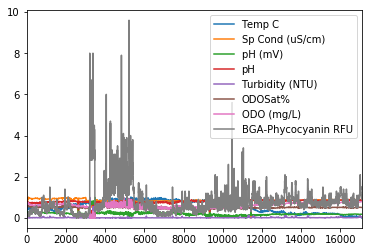

In [11]:
df_test_x[columns].plot.line()

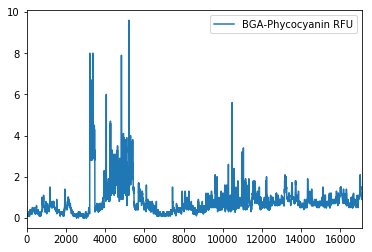

In [12]:
df_test[['BGA-Phycocyanin RFU']].plot.line()

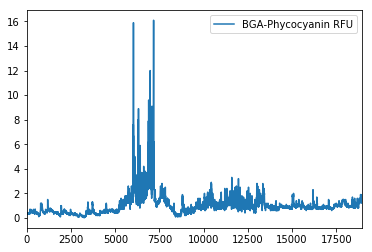

In [13]:
df_train[['BGA-Phycocyanin RFU']].plot.line()

# Breaking apart training and test data

In [14]:
x_train = df_train_x.values
x_test = df_test_x.values
y_train = df_train['BGA-Phycocyanin RFU'].values
y_test = df_test['BGA-Phycocyanin RFU'].values

In [15]:
# offset the time series of our x and y data
time_window = 24 * 4 # time series is in 15m chunks, this window is 1 day ahead
x_train = x_train[:-time_window]
y_train = y_train[time_window:]

x_test = x_test[:-time_window]
y_test = y_test[time_window:]

In [16]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (18851, 8)
x_test shape: (16999, 8)
y_train shape: (18851,)
y_test shape: (16999,)


In [ ]:
# Reshapes time series data by adding a time steps dimension for prediction
def reshape_timeseries(x, y, time_steps):
    new_x = []
    new_y = []
    for i in range(0, len(x)-1):
        if i % time_steps == 0:
            new_y.append(y[i])
        else:
            new_x.append(x[i])
    return new_x, new_y

In [17]:
# RNN layers expect a 3D tensor with shape (batch_size, timesteps, input_dim).
# For simplicity we will start with a timestep of 1.
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)

x_train shape: (18851, 1, 8)
x_test shape: (16999, 1, 8)


# RNN Model

In [18]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
#Build the model
input_shape = (x_train.shape[1], x_train.shape[2])
learning_rate = 0.0001
dropout=0.2

model = Sequential()

model.add(LSTM(2, input_shape=input_shape, dropout=dropout))
model.add(Dense(22))
model.add(Dense(1, activation='linear', input_dim=2))
model.compile(loss='mse',
              optimizer=ks.optimizers.RMSprop(lr=learning_rate),
              metrics=['mse'])
model.build()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 22)                66        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 23        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
EPOCHS = 100
BATCH_SIZE = 10
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)


Epoch 1/100
18851/18851 [==============================] - 11s 597us/step - loss: 0.6970 - mean_squared_error: 0.6970
Epoch 2/100
18851/18851 [==============================] - 9s 481us/step - loss: 0.5019 - mean_squared_error: 0.5019
Epoch 3/100
18851/18851 [==============================] - 9s 486us/step - loss: 0.4694 - mean_squared_error: 0.4694
Epoch 4/100
18851/18851 [==============================] - 9s 494us/step - loss: 0.4470 - mean_squared_error: 0.4470
Epoch 5/100
18851/18851 [==============================] - 9s 490us/step - loss: 0.4247 - mean_squared_error: 0.4247
Epoch 6/100
18851/18851 [==============================] - 9s 493us/step - loss: 0.4022 - mean_squared_error: 0.4022
Epoch 7/100
18851/18851 [==============================] - 9s 495us/step - loss: 0.3928 - mean_squared_error: 0.3928
Epoch 8/100
18851/18851 [==============================] - 9s 502us/step - loss: 0.3769 - mean_squared_error: 0.3769
Epoch 9/100
18851/18851 [==============================] - 10s 

18851/18851 [==============================] - 10s 533us/step - loss: 0.2736 - mean_squared_error: 0.2736
Epoch 70/100
18851/18851 [==============================] - 10s 525us/step - loss: 0.2694 - mean_squared_error: 0.2694
Epoch 71/100
18851/18851 [==============================] - 10s 529us/step - loss: 0.2712 - mean_squared_error: 0.2712
Epoch 72/100
18851/18851 [==============================] - 10s 535us/step - loss: 0.2617 - mean_squared_error: 0.2617
Epoch 73/100
18851/18851 [==============================] - 10s 546us/step - loss: 0.2646 - mean_squared_error: 0.2646
Epoch 74/100
18851/18851 [==============================] - 10s 549us/step - loss: 0.2682 - mean_squared_error: 0.2682
Epoch 75/100
18851/18851 [==============================] - 10s 541us/step - loss: 0.2714 - mean_squared_error: 0.2714
Epoch 76/100
18851/18851 [==============================] - 10s 548us/step - loss: 0.2715 - mean_squared_error: 0.2715
Epoch 77/100
18851/18851 [==============================] - 1

In [ ]:
# Evaluate the results
y_pred = model.predict(x_test)
print("RMSE:", rmse(y_test, predictions))

## Save the model for deployment

In [ ]:
# ignoring dropout for deployment
K.set_learning_phase(0)
 
# Set a file path to save the model in.
model_name = "rnn_prediction_model"
model_version = "1"
tf_path = "./../../saved_models/{}/{}".format(model_name, model_version)
 
# Get the session from the Keras back-end to save the model in TF format.
with K.get_session() as sess:
    tf.saved_model.simple_save(sess, tf_path, inputs={'input': model.input}, outputs={t.name: t for t in model.outputs})
